Device: cpu
Model Path: ../Data/best_efficientnet_b4.pth
Test Dataset: ../Data/CLASSIFICATION_ROIS_128x128
Loaded 3057 test images.
Detected Classes: ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

Loading EfficientNet-B4 model (Offline)...
Model loaded successfully.

Running inference on test dataset...


Inference Progress: 100%|██████████| 96/96 [02:03<00:00,  1.28s/batch]



Inference complete.

Classification Report:

                 precision    recall  f1-score   support

   Missing_hole       1.00      1.00      1.00       497
     Mouse_bite       0.99      0.94      0.96       502
   Open_circuit       0.99      0.98      0.98       511
          Short       0.88      0.99      0.93       523
           Spur       0.97      0.95      0.96       501
Spurious_copper       1.00      0.95      0.97       523

       accuracy                           0.97      3057
      macro avg       0.97      0.97      0.97      3057
   weighted avg       0.97      0.97      0.97      3057



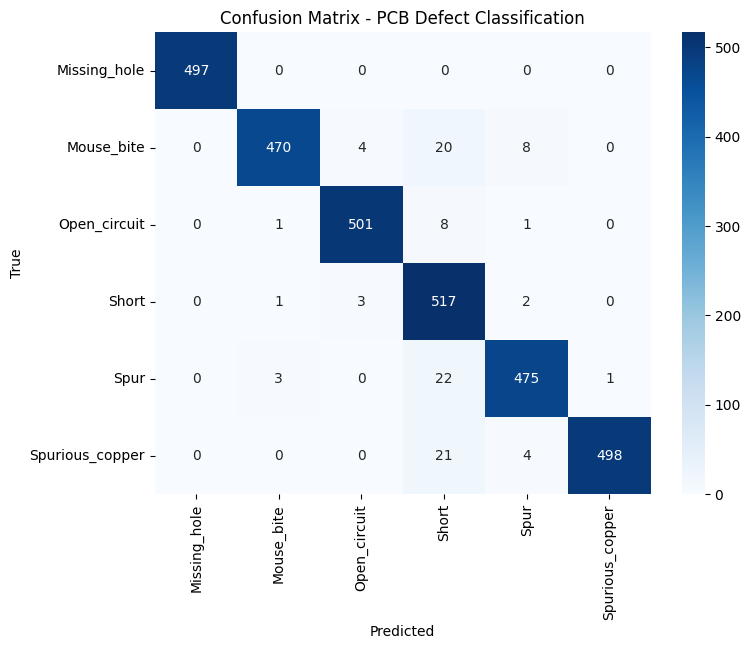

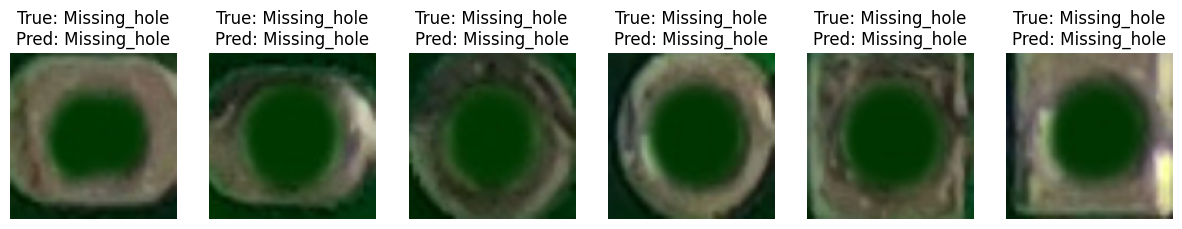

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from timm import create_model

DEVICE = "cpu"

MODEL_PATH = "../Data/best_efficientnet_b4.pth"
TEST_DIR = "../Data/CLASSIFICATION_ROIS_128x128"

CLASS_NAMES = [
    'Missing_hole',
    'Mouse_bite',
    'Open_circuit',
    'Short',
    'Spur',
    'Spurious_copper'
]

print(f"Device: {DEVICE}")
print(f"Model Path: {MODEL_PATH}")
print(f"Test Dataset: {TEST_DIR}")

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Loaded {len(test_dataset)} test images.")
print(f"Detected Classes: {test_dataset.classes}")

print("\nLoading EfficientNet-B4 model (Offline)...")

model = create_model('efficientnet_b4', pretrained=False, num_classes=len(CLASS_NAMES))
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

print("Model loaded successfully.\n")

print("Running inference on test dataset...")

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Inference Progress", unit="batch"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nInference complete.")

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - PCB Defect Classification')
plt.show()

def show_predictions(dataset, num_images=6):
    model.eval()
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        image, label = dataset[i]
        img_tensor = image.unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output = model(img_tensor)
            _, pred = torch.max(output, 1)
        img_np = image.permute(1, 2, 0).numpy()
        img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        img_np = np.clip(img_np, 0, 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_np)
        plt.title(f"True: {CLASS_NAMES[label]}\nPred: {CLASS_NAMES[pred]}")
        plt.axis('off')
    plt.show()

show_predictions(test_dataset, num_images=6)